<a href="https://colab.research.google.com/github/RahulTechTutorials/Deep_learning/blob/master/Image_Captioning_Deep_Learning_CNN_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries/Dataset**

<b><font color="blue"> a. Import the required libraries </font></b> 

In [55]:
import keras
import os, shutil
import numpy as np
import pandas as pd
import cv2
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import shutil
import tensorflow as tf
from numpy import array, argmax
from tqdm import tqdm
from os import listdir
from pickle import dump, load
from keras import layers,models
from keras import optimizers
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential, load_model
from keras.layers.merge import add
from keras.layers import Conv2D,MaxPool2D, Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from tensorflow.keras.utils import to_categorical
##from keras.applications import vgg16

In [4]:
###Mounting my google drive to colab so as to access the Dataset uploaded there.

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


<b><font color="blue"> b. Check the GPU available (recommended-use free GPU provided by Google Colab). </font></b> 

In [3]:
##To check if the GPU is activated or not on the Colab Notebook. This is essential as otherwise the Deep Neural Network
##will take a long time to train on CPUs.
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# **Check the GPU availability**

In [5]:
###GPU qouta is exhausted on Colab hence commenting this code

# memory footprint support libraries/code - This is to check how much of the shared GPU is already been utilized
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 


  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=0efd916b004afe92557c61cf98d03bcf79c8977d5d7867c45aabc831ca921706
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil
Gen RAM Free: 12.3 GB  | Proc size: 877.5 MB
GPU RAM Free: 11320MB | Used: 121MB | Util   1% | Total 11441MB


## **Setting up the Base Directory**

In [21]:
##Setting my home directory

os.chdir('/gdrive/My Drive/MTech Assignment Semester 3/DL Assignment/Assignment_2/Input')
print(os.getcwd())
print(os.listdir())
base_dir = '/gdrive/My Drive/MTech Assignment Semester 3/DL Assignment/Assignment_2/Input'
input_image_dir = os.path.join(base_dir,'Flicker8k_Dataset/')
print('input_image_dir :',input_image_dir)
input_lables_dir = os.path.join(base_dir,'Lables/')
print('input_lables_dir : ',input_lables_dir)
print(os.listdir(input_lables_dir))

/gdrive/My Drive/MTech Assignment Semester 3/DL Assignment/Assignment_2/Input
['Lables', 'Images', 'Flicker8k_Dataset', 'train_dir', 'test_dir', 'features', 'model.h5', 'model_25.h5', 'Google_Photo_for_testing_model', 'final_model_20.h5', 'final_model_25.h5']
input_image_dir : /gdrive/My Drive/MTech Assignment Semester 3/DL Assignment/Assignment_2/Input/Flicker8k_Dataset/
input_lables_dir :  /gdrive/My Drive/MTech Assignment Semester 3/DL Assignment/Assignment_2/Input/Lables/
['set_0.pkl']


<b><font color="blue"> 1. Read the pickle file and convert the data into the correct format which could be used for ML model. </font></b> 

In [8]:
lables = pd.read_pickle(input_lables_dir + '/set_0.pkl' )
print('checking the lables from the pickeled file')
lables[:3]

checking the lables from the pickeled file


['318667317_108c402140.jpg#4\tA man in a black hoodie be hold a paper sign .',
 '2072574835_febf0c5fb9.jpg#4\tThree race dog be run out of the start gate on a track .',
 '3083016677_5782bc337c.jpg#4\tTwo motorcycle with two rider each .']

## **Preprocessing of the Caption/Label dataset for Language Model**

<b>a) Converting the captions into a Dictionary with Image name as Key and Caption as the values. Since there are multiple caption available for one image, We have created a list of those Captions. </b>

In [9]:
label_dict = dict()
for lines in lables:                                   ## opening the line from caption
  try:
    line = lines.split('\t')                          ## spliting by tab as delimiter 
    if line[0][:-2] not in label_dict:                ## checking if the key is not in label disctionary
      label_dict[line[0][:-2]] = [line[1]]            ## If not there, then add the new key value pair  
    else :
      label_dict[line[0][:-2]].append(line[1])        ## If present, then append that to the value list
  except:
    pass
label_dict_crosscheck = copy.deepcopy(label_dict )   ##Taking a back up of the label_dict as it will be encoded with indexes later
print('Checking one value')
for k,v in label_dict.items(): 
    print(k,v) 
    break

Checking one value
318667317_108c402140.jpg ['A man in a black hoodie be hold a paper sign .', 'A homeless man carry a sign that say " hungry " .', 'A bearded man hold a sign .', 'A man in a black hoodie hold a small sign .']


<b> b) Creating a function to append the startofstr and endofstr </b>

In [10]:
def preprocess(str):                                        ##function to append the startofcaption and endofcaption for language model
  str = 'startofcaption ' + str.lower() + ' endofcaption'     
  return str

for k,v in label_dict.items():               ##traversing through the lable dictionary to append the updated captions 
  new_val = []
  for val in v:
    val = preprocess(val)
    new_val.append(val)
  label_dict[k] = new_val

print('Checking the value after appending startofcaption and endofcaption')
for k,v in label_dict.items(): 
    print(k,v) 
    break

Checking the value after appending startofcaption and endofcaption
318667317_108c402140.jpg ['startofcaption a man in a black hoodie be hold a paper sign . endofcaption', 'startofcaption a homeless man carry a sign that say " hungry " . endofcaption', 'startofcaption a bearded man hold a sign . endofcaption', 'startofcaption a man in a black hoodie hold a small sign . endofcaption']


<b> c) Creating a Vocabulary </b>

In [11]:
## Creating a vocabulary with distinct words with key as the word and value as index number
word_dict = {}
count_key = 1
for v in label_dict.values():
  for val in v:
    for word in val.split():
      if word not in word_dict.keys():
        word_dict[word] = count_key
        count_key += 1
print('checking the length of word_dict : ',len(word_dict))
print('checking couple of values from dictionary :',list(word_dict.items())[:5])
print('checking black value : ',word_dict['black'])

checking the length of word_dict :  5562
checking couple of values from dictionary : [('startofcaption', 1), ('a', 2), ('man', 3), ('in', 4), ('black', 5)]
checking black value :  5


<b>d) Encoding the Captions/Labels into sequence of indexes from dictionary</b>

In [12]:
for k,v in label_dict.items():   ##Encoding the captions with the help of above dictionary so as to make it understandable by machine
  encoded_val = []
  for val in v:
    encoded_cap = []
    for word in val.split():
      index = word_dict[word]   ##Getting the index from the dictionary
      encoded_cap.append(index) ##Appending the index in the encoded captions list    
    encoded_val.append(encoded_cap)
  label_dict[k] = encoded_val   ##Updating the encoded Value against the key in the Label Dictionary
print('Checking the first two records after encoding',list(label_dict.items())[:2])

Checking the first two records after encoding [('318667317_108c402140.jpg', [[1, 2, 3, 4, 2, 5, 6, 7, 8, 2, 9, 10, 11, 12], [1, 2, 13, 3, 14, 2, 10, 15, 16, 17, 18, 17, 11, 12], [1, 2, 19, 3, 8, 2, 10, 11, 12], [1, 2, 3, 4, 2, 5, 6, 8, 2, 20, 10, 11, 12]]), ('2072574835_febf0c5fb9.jpg', [[1, 21, 22, 23, 7, 24, 25, 26, 27, 28, 29, 30, 2, 31, 11, 12], [1, 32, 23, 33, 22, 34, 7, 24, 25, 26, 2, 29, 30, 2, 31, 11, 12], [1, 23, 4, 2, 22, 11, 12]])]


<b>e) Creating inverse dictionary to cross check the encoding</b>

In [13]:
inv_word_dict = {(v,k) for k,v in word_dict.items()}    ##Creating an inverse dictionary to decode the encoding 
inv_word_dict = dict(inv_word_dict)
print('checking the values back with inverse dictionary',inv_word_dict[1], inv_word_dict[3])
print('Converting the first caption and checking')
output = []
for caption in label_dict['318667317_108c402140.jpg']:  ##Decoding the captions for one image and validating 
  cap_output = []
  for num in caption:
    cap_output.append(inv_word_dict[num])
  output.append(cap_output)
print(output)


checking the values back with inverse dictionary startofcaption man
Converting the first caption and checking
[['startofcaption', 'a', 'man', 'in', 'a', 'black', 'hoodie', 'be', 'hold', 'a', 'paper', 'sign', '.', 'endofcaption'], ['startofcaption', 'a', 'homeless', 'man', 'carry', 'a', 'sign', 'that', 'say', '"', 'hungry', '"', '.', 'endofcaption'], ['startofcaption', 'a', 'bearded', 'man', 'hold', 'a', 'sign', '.', 'endofcaption'], ['startofcaption', 'a', 'man', 'in', 'a', 'black', 'hoodie', 'hold', 'a', 'small', 'sign', '.', 'endofcaption']]


<b> f) Checking the max length of the caption for creating One Hot Encoding vector</b>

In [34]:
print('Checking the Max length of the caption')
max_length = 0 
for v in label_dict.values():
  for val in v:
    if len(val) > max_length:
      max_length = len(val)
print('Maximum Length max_length : ', max_length)

Checking the Max length of the caption
Maximum Length max_length :  36


# **Preprocessing of Image dataset for CNN model**

In [23]:
print('Checking the files names from the folder')
os.listdir(input_image_dir)[:5]
##Reading the "file names as Path" from the folder using the glob library
images = glob(input_image_dir+'*.jpg')
print('Checking the images object :',images[:2])

Checking the files names from the folder
Checking the images object : ['/gdrive/My Drive/MTech Assignment Semester 3/DL Assignment/Assignment_2/Input/Flicker8k_Dataset/241345721_3f3724a7fc.jpg', '/gdrive/My Drive/MTech Assignment Semester 3/DL Assignment/Assignment_2/Input/Flicker8k_Dataset/2265096094_8cc34d669c.jpg']


<b><font color="blue"> a. Plot at least two samples and their captions (use matplotlib/seaborn/any other library). </font></b> 

241345721_3f3724a7fc.jpg : ['one football player in a red jersey jump onto a player wear a white jersey', 'An American footballer wear red be push a player in white to the ground .', 'Two football player bang into each other during a football game .']
2265096094_8cc34d669c.jpg : ['A person be pull in a cart by a donkey .', 'A mule pull a carriage with a man inside along a dirt path .', 'A donkey pull a cart with a boy in it take a brake .']


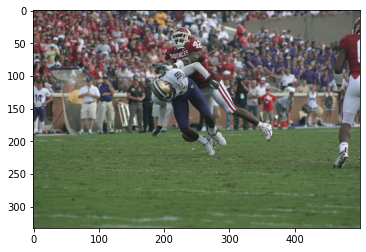

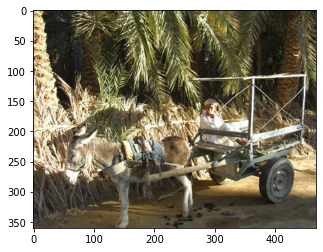

In [35]:
for i in range(2):
  plt.figure()
  file_name = images[i].split('/')[-1]
  captions = label_dict_crosscheck[file_name]
  print(file_name,':' ,captions  )
  img = cv2.imread(images[i]) ##Reading the Image file
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  ###Converting the BGR to RGB channel scheme
  plt.imshow(img)

<b><font color="blue"> b. Bring the train and test data in the required format. </font></b> 

In [29]:
##Creating two directories for Test and Train split
##os.mkdir('train_dir').  --Commenting for reproducability
##os.mkdir('test_dir').   --Commenting for reproducability
os.chdir('/gdrive/My Drive/MTech Assignment Semester 3/DL Assignment/Assignment_2/Input/')
print(os.getcwd())
print(os.listdir())
##creating destination folders for copying the Train and Test images into the respective folders (train_dir and test_dir)
image_train_dest = os.path.join(base_dir,'train_dir')
image_test_dest = os.path.join(base_dir,'test_dir')
print('train_dir path : ',image_train_dest)
print('test_dir path : ',image_test_dest)
##Creating a list of all the files name from train and test sets
image_train_dest_list = [i.split('/')[-1] for i in images[:7000]]
image_test_dest_list = [i.split('/')[-1] for i in images[7000:]]
print('Size of Train set : ',len(image_train_dest_list)) 
print('Size of Test set : ',len(image_test_dest_list))
print('Size of Original set : ',len(images))
##Creating variables for storing the list of "file names as path" from train and test data folder 
image_train_dest_list_with_path = [i for i in images[:7000]]
image_test_dest_list_with_path = [i for i in images[7000:]]
print('Size of image_train_dest_list_with_path : ',len(image_train_dest_list_with_path)) 
print('Size of image_test_dest_list_with_path : ',len(image_test_dest_list_with_path))
print('Size of Original set : ',len(images))
print('Checking destination train list', image_train_dest_list[:2])
print('Checking destination test list', image_test_dest_list[:2])
print('Checking the input_image_dir : ',input_image_dir)
###Copying the 7000 files from Input/Flicker8k_Dataset folder to Input/train_dir for training purpose
'''
for fname in image_train_dest_list:    ###Commenting the code for reproducability
  src = os.path.join(input_image_dir,fname)
  dst = os.path.join(image_train_dest,fname)
  shutil.copyfile(src,dst)
'''
###Copying the rest of the 1091 files from Input/Flicker8k_Dataset folder to Input/test_dir for testing purpose
'''
for fname in tqdm(image_test_dest_list):  ###Commenting the code for reproducability
  src = os.path.join(input_image_dir,fname)
  dst = os.path.join(image_test_dest,fname)
  shutil.copyfile(src,dst)
  '''
##Creating a dictionary for training lables from the original dictionary
label_dict_train = [(k,v) for k,v in label_dict.items() if k in image_train_dest_list]
label_dict_train = dict(label_dict_train)
##Creating a dictionary for testing lables from the original dictionary
label_dict_test = [(k,v) for k,v in label_dict.items() if k in image_test_dest_list]
label_dict_test = dict(label_dict_test)

print('Checking the training dictionary label_dict_train : ',list(label_dict_train.items())[:2])
print('Checking the testing dictionary label_dict_train : ',list(label_dict_test.items())[:2])

/gdrive/My Drive/MTech Assignment Semester 3/DL Assignment/Assignment_2/Input
['Lables', 'Images', 'Flicker8k_Dataset', 'train_dir', 'test_dir', 'features', 'model.h5', 'model_25.h5', 'Google_Photo_for_testing_model', 'final_model_20.h5', 'final_model_25.h5']
train_dir path :  /gdrive/My Drive/MTech Assignment Semester 3/DL Assignment/Assignment_2/Input/train_dir
test_dir path :  /gdrive/My Drive/MTech Assignment Semester 3/DL Assignment/Assignment_2/Input/test_dir
Size of Train set :  7000
Size of Test set :  1091
Size of Original set :  8091
Size of image_train_dest_list_with_path :  7000
Size of image_test_dest_list_with_path :  1091
Size of Original set :  8091
Checking destination train list ['241345721_3f3724a7fc.jpg', '2265096094_8cc34d669c.jpg']
Checking destination test list ['3724113279_99b6e5bf41.jpg', '58363930_0544844edd.jpg']
Checking the input_image_dir :  /gdrive/My Drive/MTech Assignment Semester 3/DL Assignment/Assignment_2/Input/Flicker8k_Dataset/
Checking the traini

# <b>Using VGG-16 model trained on ImageNetdataset for image feature extraction</b>

<b><font color="blue"> a.Use Pretrained VGG-16 model trained on ImageNetdataset (availablepublicly on google) for image feature extraction. </font></b> 

In [36]:
# Creating a function to extract the features from each photo in the directory
def extract_features(dir):
	model = VGG16()
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
	features = dict()
 
	for name in tqdm(listdir(dir)):
		filename = dir + '/' + name
		image = load_img(filename, target_size=(224, 224))
		image = img_to_array(image)
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		image = preprocess_input(image)
		feature = model.predict(image, verbose=0)
		image_id = name
		features[image_id] = feature
	return features


# Running the extract_features function to extract features from Training data set and pickle the file to features.pkl into features folder
'''
features = extract_features(image_train_dest)     ###Commenting for Reproducability  
print('Extracted Features: %d' % len(features))
# save to file
os.chdir('/gdrive/My Drive/MTech Assignment Semester 3/DL Assignment/Assignment_2/Input/features')
dump(features, open('features.pkl', 'wb'))
'''
###Reloading the pickled file to load the Image features in the object
file = open("/gdrive/My Drive/MTech Assignment Semester 3/DL Assignment/Assignment_2/Input/features/features.pkl",'rb')
features = load(file)
print('feature object loaded from pickled file')

feature object loaded from pickled file


# **Creating generator function for feeding to RNN model**

In [37]:
Batch_size = 5000
VOCAB_SIZE = len(word_dict)

def generator(photo, caption):
    n_samples = 0
    
    X = []
    y_in = []
    y_out = []
    
    for k, vv in caption.items():
        for v in vv:
            for i in range(1, len(v)):
                X.append(photo[k])

                in_seq= [v[:i]]
                out_seq = v[i]

                in_seq = pad_sequences(in_seq, maxlen=max_length, padding='post', truncating='post')[0]
                out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

                y_in.append(in_seq)
                y_out.append(out_seq)
            
    return X, y_in, y_out

## **Preprocessing of the Image Feature Dictionary**

In [40]:
print('--> Checking the length of the dictionaries')
print(len(image_train_dest_list), len(label_dict), len(label_dict_train))
print('--> Creating a dictionary with Images features as Values and Key as image Name')
images_features = [(k,v) for k,v in features.items() if k in label_dict_train.keys()]
images_features = dict(images_features)
print('--> Restricting the Training dictionary to only those images which are present in features')
label_dict_train_gen = [(k,v) for k,v in label_dict_train.items() if k in features.keys()]
label_dict_train_gen = dict(label_dict_train_gen)
print('--> Checking the length of images_features and label_dict_train_gen')
len(images_features), len(label_dict_train_gen)
print('--> Reducing the Image Feature dictionary to 1500 samples as training was taking a lot of time')
images_features_reduced = [(k,v) for n,(k,v) in enumerate(images_features.items()) if n <= 1500]
images_features_reduced = dict(images_features_reduced)
print('--> Reducing the training dictionary according to reduced Image Feature dictionary for performance purpose')
label_dict_train_gen_reduced = [(k,v) for n,(k,v) in enumerate(label_dict_train_gen.items()) if k in images_features_reduced.keys()   ]
label_dict_train_gen_reduced = dict(label_dict_train_gen_reduced)

--> Checking the length of the dictionaries
7000 8037 6950
--> Creating a dictionary with Images features as Values and Key as image Name
--> Restricting the Training dictionary to only those images which are present in features
--> Checking the length of images_features and label_dict_train_gen
--> Reducing the Image Feature dictionary to 1500 samples as training was taking a lot of time
--> Reducing the training dictionary according to reduced Image Feature dictionary for performance purpose


In [46]:
##Calling the generator function to prepare the Inputs
print('--> Calling the generator function to prepare the Inputs ')
X, y_in, y_out = generator(images_features_reduced, label_dict_train_gen_reduced) 
print('Length of X : ',len(X))
print('Length of y_in : ',len(y_in))
print('Length of y_out : ',len(y_out))
print('--> Converting the Lists to Numpy Arrays ')
X = np.array(X)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')
X = X.reshape(59755,4096) ##Reshaping the X input feature to (59755,4096)
print('X Shape : ',X.shape)
print('y_in Shape : ',y_in.shape)
print('y_out Shape : ',y_out.shape)

--> Calling the generator function to prepare the Inputs 
Length of X :  59755
Length of y_in :  59755
Length of y_out :  59755
--> Converting the Lists to Numpy Arrays 
X Shape :  (59755, 4096)
y_in Shape :  (59755, 36)
y_out Shape :  (59755, 5562)


# **Model Building**

<b><font color="blue"> b. Create 3 layered LSTM layer model and other relevant layers for image caption generation.                                          
</font></b> 

<b><font color="blue"> c. Add L2 regularization to all theLSTMlayers. </font></b>

<b><font color="blue"> d. Add one layer of dropout at the appropriate position and give reasons.
 </font></b>

<b><font color="blue">  e. Choose the appropriate activation function for all the layers.  </font></b>

<b><font color="blue"> f. Print the model summary.</font></b>

In [77]:
max_len = max_length
vocab_size = len(word_dict)
image_input = Input(shape = (4096,)) ##Defining the input  
drop_out = Dropout(0.5)(image_input)
dense = Dense(16, activation= 'relu') (drop_out)

#LSTM model - Sequential
text_input = Input(shape=(max_length,))
embeded = Embedding(vocab_size, 256, mask_zero=True)(text_input)
drop_out_text = Dropout(0.5)(embeded)
lstm_1 = LSTM(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)) (drop_out_text) ###LSTM Layer with L2 regularization   
lstm_2 = LSTM(64, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01), dropout = 0.5) (lstm_1)  ###LSTM Layer with L2 regularization and drop out. Took Dropout for regularization in the hidden LSTM layer.  
lstm_3 = LSTM(16, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.01)) (lstm_2) ###LSTM Layer with L2 regularization

#Integration of both models
decoder1 = add([dense, lstm_3])
decoder2 = Dense(16, activation = 'relu') (decoder1)
outputs = Dense(vocab_size, activation = 'softmax') (decoder2)
print('--> Model Building Finished')

--> Model Building Finished


# **Model Compiling and Model Summary**

<b><font color="blue"> a. Compile the model with the appropriate loss function. 
</font></b>

<b><font color="blue"> b. Use an appropriate optimizer. Give reasons for the choice of learning rate and its value.</font></b>

In [79]:
#Model Compiling
final_model = Model(inputs=[image_input, text_input], outputs = outputs)
final_model.compile(loss='categorical_crossentropy', optimizer='adam')
##Model Summary 
print(final_model.summary())

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 36)]         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 36, 256)      1423872     input_23[0][0]                   
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 36, 256)      0           embedding_10[0][0]               
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 4096)]       0                                            
___________________________________________________________________________________________

# **Model Training**

<b><font color="blue"> a. Train the model for an appropriate number of epochs.Print the train and validationloss for each epoch. Use the appropriate batch size.
</font></b> 


<b><font color="blue"> b. Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.
</font></b> 

In [157]:
##Taking Epoch as 25 , Parameter as Loff Function, Batch size = 512
final_model.fit([X, y_in], y_out, batch_size=512, epochs=25)

Epoch 1/25
117/117 [==============================] - 112s 748ms/step - loss: 7.0956
Epoch 2/25
117/117 [==============================] - 87s 747ms/step - loss: 5.0013
Epoch 3/25
117/117 [==============================] - 88s 749ms/step - loss: 4.8146
Epoch 4/25
117/117 [==============================] - 89s 759ms/step - loss: 4.6779
Epoch 5/25
117/117 [==============================] - 88s 754ms/step - loss: 4.5803
Epoch 6/25
117/117 [==============================] - 89s 764ms/step - loss: 4.5081
Epoch 7/25
117/117 [==============================] - 87s 747ms/step - loss: 4.4540
Epoch 8/25
117/117 [==============================] - 87s 747ms/step - loss: 4.4104
Epoch 9/25
117/117 [==============================] - 88s 748ms/step - loss: 4.3748
Epoch 10/25
117/117 [==============================] - 87s 747ms/step - loss: 4.3484
Epoch 11/25
117/117 [==============================] - 88s 754ms/step - loss: 4.3218
Epoch 12/25
117/117 [==============================] - 88s 748ms/step - l

In [159]:
final_model.save('model_25.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# **Reloading of the model**

In [52]:
###Reloading the model from the pickled file to load the Image features in the object
model = load_model('/gdrive/My Drive/MTech Assignment Semester 3/DL Assignment/Assignment_2/Input/model_25.h5')
print('--> Model reloaded from the pickled file')

--> Model reloaded from the pickled file


# **Prediction - Predicting the caption from Testing Set**

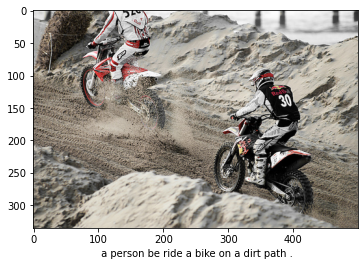

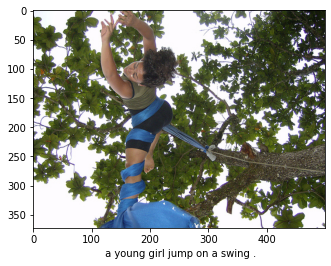

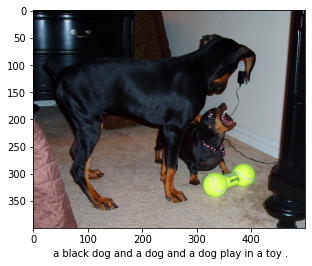

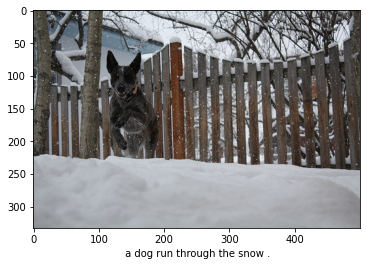

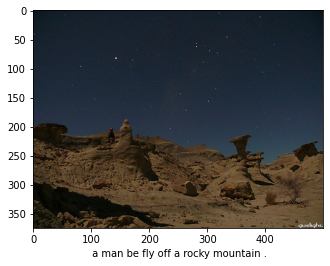

In [144]:
for i in range(5):   ## Predicting the captions for 5 random images from the test set
    
    no = np.random.randint(1,1090,(1,1))[0,0]                                       ## Picking up a random number betwen 1 and 1090 for selecting an image from the Test set
    vgg_model = VGG16()                                                             ##Creating VGG model object    
    vgg_model.layers.pop()                                              
    vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output) ##Setting last but one layer, dense layer as the output layer  
    test_features = dict()                                                          ##Initializing the dictionary var for storing the test features\
    image = load_img(image_test_dest_list_with_path[no], target_size=(224, 224))    ##Loading the image from test folder
    image = img_to_array(image)                                                     ##Converting the image to array  
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))      ##Reshaping the array 
    image = preprocess_input(image)
    test_feature = vgg_model.predict(image, verbose=0).reshape(1,4096)              ##Predicting the test features with vgg_model

    test_img_path = image_test_dest_list_with_path[no]                              ##Reading the image with path
    test_img = cv2.imread(test_img_path)                                            ##Reading the image from the test folder to display
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)                            ##Changing the color scheme from BGR to RGB
    text_inp = ['startofcaption']                                                   ##Appending the Start of Caption
    count = 0
    caption = ''
    while count < 25:
        count += 1

        encoded = []
        for i in text_inp:
            encoded.append(word_dict[i])
        encoded = [encoded]
        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=max_length) ##Padding the sequence to create One hot encoded vector
        prediction = np.argmax(model.predict([test_feature, encoded]))              ## Passing the Test Features and Encoded string(One hot vector) to predict the next word
        sampled_word = inv_word_dict[prediction]
        if sampled_word == 'endofcaption':                                          ##Checking for endofcaption to finish predicting through LSTM 
            break
        caption = caption + ' ' + sampled_word                                      ##Concatenate the next word to the output string
        text_inp.append(sampled_word)
        
    plt.figure()                                                    
    plt.imshow(test_img)                                                            ##Display the Image
    plt.xlabel(caption)                                                             ##Display the predicted Caption

# **Model Evaluation** 

<b><font color="blue"> a. Take a random image from google and generate caption for that image.
</font></b> 

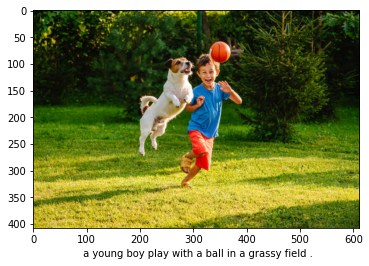

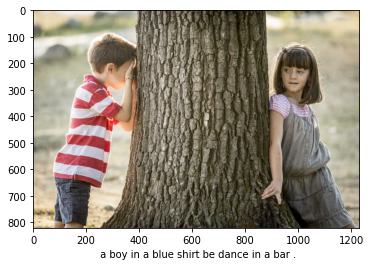

In [51]:
##Google photo testing for Caption
os.chdir('/gdrive/My Drive/MTech Assignment Semester 3/DL Assignment/Assignment_2/Input/Google_Photo_for_testing_model')
google_image_1 = ('/gdrive/My Drive/MTech Assignment Semester 3/DL Assignment/Assignment_2/Input/Google_Photo_for_testing_model/google_image_for_test_1.jpeg')
google_image_2 = ('/gdrive/My Drive/MTech Assignment Semester 3/DL Assignment/Assignment_2/Input/Google_Photo_for_testing_model/google_image_for_test_2.jpeg')

google_photo_input = []

google_photo_input.append(google_image_1)
google_photo_input.append(google_image_2)

for photo in google_photo_input:
    vgg_model = VGG16()
    vgg_model.layers.pop()
    vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)
    test_features = dict()

    image = load_img(photo, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    test_feature = vgg_model.predict(image, verbose=0).reshape(1,4096)

    
    test_img = cv2.imread(photo)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


    text_inp = ['startofcaption']

    count = 0
    caption = ''
    while count < 25:
        count += 1

        encoded = []
        for i in text_inp:
            encoded.append(word_dict[i])

        encoded = [encoded]

        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=max_length)


        prediction = np.argmax(model.predict([test_feature, encoded]))


      ##  sampled_word = inv_dict[prediction]
        sampled_word = inv_word_dict[prediction]
        if sampled_word == 'endofcaption':
            break
        caption = caption + ' ' + sampled_word
        text_inp.append(sampled_word)
        
    plt.figure()
    plt.imshow(test_img)
    plt.xlabel(caption)